In [ ]:
import os
import re
import sys

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

c:\Users\filip\Projects\Neural_IR_Expansion\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data loading and processing

Since I was having problems with the ir_datasets library, I downloaded locally the dataset files from https://ciir.cs.umass.edu/downloads/Antique/

### Load the data

In [ ]:
dataset_path = "data/Dataset"

antique_collection = os.path.join(dataset_path, "antique-collection.txt")
docs_df_cols = ['answer_id', 'answer_text']
docs = pd.read_csv(antique_collection, sep='\t', header=None, names=docs_df_cols)

antique_train_queries = os.path.join(dataset_path, "antique-train-queries.txt")
train_queries_cols = ["query_id", "query_text"]
train_queries = pd.read_csv(antique_train_queries, sep='\t', header=None, names=train_queries_cols)

antique_train_qrels = os.path.join(dataset_path, "antique-train.qrel.txt")
train_qrels_cols = ["query_id", "relevance_type", "answer_id", "relevance"]
train_qrels = pd.read_csv(antique_train_qrels, sep=r'\s+', header=None, names=train_qrels_cols) # the sep handles the separation between columns " " and "\t"

antique_test_queries = os.path.join(dataset_path, "antique-test-queries.txt")
test_queries_cols = ["query_id", "query_text"]
test_queries = pd.read_csv(antique_test_queries, sep='\t', header=None, names=test_queries_cols)

antique_test_qrels = os.path.join(dataset_path, "antique-test.qrel.txt")
test_qrels_cols = ["query_id", "relevance_type", "answer_id", "relevance"]
test_qrels = pd.read_csv(antique_test_qrels, sep=r'\s+', header=None, names=test_qrels_cols) # the sep handles the separation between columns " " and "\t"

From the dataset readme, we know that the "doc_id" column contains two separate informations, so we can split the "doc_id" column to get the "query_id" and "answer_n" separately

In [ ]:
docs[['query_id', 'answer_n']] = docs['answer_id'].str.split('_', expand=True)
train_qrels[['query_id', 'answer_n']] = train_qrels['answer_id'].str.split('_', expand=True)
test_qrels[['query_id', 'answer_n']] = test_qrels['answer_id'].str.split('_', expand=True)

docs['query_id'] = docs['query_id'].astype(int)
train_qrels['query_id'] = train_qrels['query_id'].astype(int)
test_qrels['query_id'] = test_qrels['query_id'].astype(int)

docs['answer_n'] = docs['answer_n'].astype(int)
train_qrels['answer_n'] = train_qrels['answer_n'].astype(int)
test_qrels['answer_n'] = test_qrels['answer_n'].astype(int)

Now, let's see how our data looks like

In [4]:
print(f"docs shape: {docs.shape}")
print(f"train_queries shape: {train_queries.shape}")
print(f"train_qrels shape: {train_qrels.shape}")
print(f"test_queries shape: {test_queries.shape}")
print(f"test_qrels shape: {test_qrels.shape}")

docs shape: (403458, 4)
train_queries shape: (2426, 2)
train_qrels shape: (27422, 5)
test_queries shape: (200, 2)
test_qrels shape: (6589, 5)


### Null values

In [5]:
print(f"{docs.isnull().sum()}\n")
print(f"{train_queries.isnull().sum()}\n")
print(f"{train_qrels.isnull().sum()}\n")
print(f"{test_queries.isnull().sum()}\n")
print(test_qrels.isnull().sum())

answer_id      0
answer_text    5
query_id       0
answer_n       0
dtype: int64

query_id      0
query_text    0
dtype: int64

query_id          0
relevance_type    0
answer_id         0
relevance         0
answer_n          0
dtype: int64

query_id      0
query_text    0
dtype: int64

query_id          0
relevance_type    0
answer_id         0
relevance         0
answer_n          0
dtype: int64


We have 1 column in docs ("text") with 5 null values. It probably corresponds to some uploaded but empty answers by users

In [6]:
docs_nulls = docs[docs.isnull().any(axis=1)]
docs_nulls

,answer_id,answer_text,query_id,answer_n
5378,1940280_3,NaN,1940280,3
31936,435733_1,NaN,435733,1
35357,3975689_3,NaN,3975689,3
140950,2677531_4,NaN,2677531,4
262306,493662_4,NaN,493662,4


In [7]:
matching_qrels = train_qrels.merge(docs_nulls[['query_id', 'answer_id']], on=['query_id', 'answer_id'])
matching_qrels

,query_id,relevance_type,answer_id,relevance,answer_n
0,2677531,E0,2677531_4,3,4


Let's get rid of it

In [8]:
train_qrels = train_qrels[train_qrels['answer_id'] != "2677531_4"]

matching_qrels = train_qrels.merge(docs_nulls[['query_id', 'answer_id']], on=['query_id', 'answer_id'])
matching_qrels

,query_id,relevance_type,answer_id,relevance,answer_n


### Duplicates

In [9]:
print("Duplicate rows:\n")
print("docs:", docs.duplicated().sum())
print("train_queries:", train_queries.duplicated().sum())
print("train_qrels:", train_qrels.duplicated().sum())
print("test_queries:", test_queries.duplicated().sum())
print("test_qrels:", test_qrels.duplicated().sum())

Duplicate rows:

docs: 0
train_queries: 0
train_qrels: 0
test_queries: 0
test_qrels: 35


In [10]:
test_qrels_duplicates = test_qrels[test_qrels.duplicated(keep=False)].sort_values(by=test_qrels.columns.tolist())
test_qrels_duplicates

,query_id,relevance_type,answer_id,relevance,answer_n
1351,144229,Q0,144229_5,1,5
3525,144229,Q0,144229_5,1,5
3248,229566,Q0,229566_0,2,0
4376,229566,Q0,229566_0,2,0
1546,230487,Q0,230487_0,4,0
...,...,...,...,...,...
5387,4169123,Q0,4169123_11,1,11
1870,4225209,Q0,4225209_3,2,3
3090,4225209,Q0,4225209_3,2,3
1851,4235114,Q0,4235114_1,1,1


Let's drop the duplicates

In [11]:
test_qrels.drop_duplicates(inplace=True)
print("test_qrels duplicates:", test_qrels.duplicated().sum())
len(test_qrels)

test_qrels duplicates: 0


6554

### Merge the datasets

Now we want to merge the datasets in order to have only two for train and test (we will extract also a validation set from the train).

So, let's check if all the query_id's in the query df's for train and test appear also in the qrels df's, and if so we can start merging these two datasets

In [ ]:
train_queries_in_qrels = set(train_queries['query_id']).issubset(set(train_qrels['query_id']))
print("All train_queries in train_qrels?", train_queries_in_qrels)

train_qrels_extra_queries = set(train_qrels['query_id']) - set(train_queries['query_id'])
print("Train qrels query_ids NOT in train_queries:", len(train_qrels_extra_queries))

All train_queries in train_qrels? True
Train qrels query_ids NOT in train_queries: 0


In [ ]:
test_queries_in_qrels = set(test_queries['query_id']).issubset(set(test_qrels['query_id']))
print("All test_queries in test_qrels?", test_queries_in_qrels)

test_qrels_extra_queries = set(test_qrels['query_id']) - set(test_queries['query_id'])
print("Test qrels query_ids NOT in test_queries:", len(test_qrels_extra_queries))

All test_queries in test_qrels? True
Test qrels query_ids NOT in test_queries: 3676


We have some queries in the test qrels df that are not present in the test queries df, so let's drop them

In [14]:
print(len(test_qrels))
test_qrels = test_qrels[test_qrels['query_id'].isin(test_queries['query_id'])]
print(len(test_qrels))

test_qrels_extra_queries = set(test_qrels['query_id']) - set(test_queries['query_id'])
print("Test qrels query_ids NOT in test_queries:", len(test_qrels_extra_queries))

6554
2181
Test qrels query_ids NOT in test_queries: 0


Now we can merge queries and qrels for train and test

In [15]:
train_merged = pd.merge(train_qrels, train_queries, on='query_id', how='inner')
test_merged = pd.merge(test_qrels, test_queries, on='query_id', how='inner')

In [16]:
print(f"train_merged shape: {train_merged.shape}")
print(f"test_merged shape: {test_merged.shape}")

train_merged shape: (27421, 6)
test_merged shape: (2181, 6)


Check if all answer_ids in the merged DataFrames are in docs

In [ ]:
missing_train_answers = ~train_merged['answer_id'].isin(docs['answer_id'])
print("Train: answer_ids not in docs:", missing_train_answers.sum())

missing_test_answers = ~test_merged['answer_id'].isin(docs['answer_id'])
print("Test: answer_ids not in docs:", missing_test_answers.sum())

Train: answer_ids not in docs: 16
Test: answer_ids not in docs: 0


Let's drop rows with missing answer_ids

In [18]:
train_merged = train_merged[train_merged['answer_id'].isin(docs['answer_id'])]
len(train_merged)

27405

In [19]:
# Final merge
train_val_df = pd.merge(train_merged, docs[['answer_id', 'answer_text']], on='answer_id', how='inner')
test_df = pd.merge(test_merged, docs[['answer_id', 'answer_text']], on='answer_id', how='inner')

In [20]:
train_val_df['relevance'] = (train_val_df['relevance'] - 1) / 3
test_df['relevance'] = (test_df['relevance'] - 1) / 3

Now we want also to extract the validation set from train_df. We will do a 10% split.  

Splitting by query_id guarantees no overlap of queries between train and validation, altho it won't be a perfect 10% split

In [ ]:
unique_queries = train_val_df['query_id'].unique()
split_idx = int(len(unique_queries) * 0.1)  # 10% for validation

# Split query IDs
val_queries = unique_queries[:split_idx]
train_queries = unique_queries[split_idx:]

train_df = train_val_df[train_val_df['query_id'].isin(train_queries)].reset_index(drop=True)
val_df = train_val_df[train_val_df['query_id'].isin(val_queries)].reset_index(drop=True)

print(f"Train split shape: {train_df.shape}")
print(f"Validation split shape: {val_df.shape}")
print(f"Test split shape: {test_df.shape}")

Train split shape: (24685, 7)
Validation split shape: (2720, 7)
Test split shape: (2181, 7)


In [22]:
print(train_df.isnull().sum())
print(val_df.isnull().sum())
print(test_df.isnull().sum())

query_id          0
relevance_type    0
answer_id         0
relevance         0
answer_n          0
query_text        0
answer_text       0
dtype: int64
query_id          0
relevance_type    0
answer_id         0
relevance         0
answer_n          0
query_text        0
answer_text       0
dtype: int64
query_id          0
relevance_type    0
answer_id         0
relevance         0
answer_n          0
query_text        0
answer_text       0
dtype: int64


We have our clean data!  
Let's save it, so that it will be easily reusable

In [ ]:
train_df.to_csv("data/MyData/train.csv", index=False)
val_df.to_csv("data/MyData/val.csv", index=False)
test_df.to_csv("data/MyData/test.csv", index=False)

# Cross-encoder fine-tuning visualization

Let's visualize the behavior of the loss function during the fine-tuning of the cross-encoder using the auto-saved readme that comes with the save function of the model

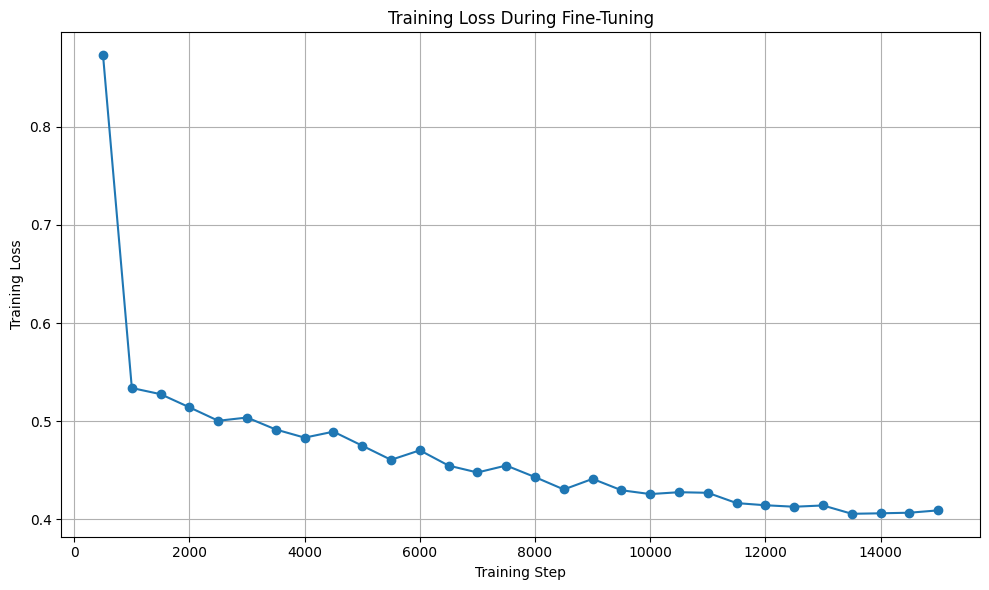

In [ ]:
import matplotlib.pyplot as plt

file_path = "models/crossencoder_fineTuning/README.md"

epochs = []
steps = []
losses = []

with open(file_path, 'r') as f:
    for i, line in enumerate(f):
        # Select the lines in the README that have the loss values
        if 272 < i < 303:
            parts = line.strip().strip('|').split('|')
            if len(parts) == 3:
                epoch = float(parts[0].strip())
                step = int(parts[1].strip())
                loss = float(parts[2].strip())
                epochs.append(epoch)
                steps.append(step)
                losses.append(loss)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o')
plt.title('Training Loss During Fine-Tuning')
plt.xlabel('Training Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# Creation of the expansion dataframes

In [ ]:
# Load the expert query expansions
expert_file = "data/Expansions/expert_user_expansion.txt"
with open(expert_file, "r") as f:
    lines = [line for line in f.readlines() if line.strip()]
    
expert_queries = []

for i, line in enumerate(lines):
    if line.startswith("Rewritten: "):
        expert_queries.append(line.replace("Rewritten: ", "").replace("\n", ""))

# Load the novice query expansions
novice_file = "data/Expansions/novice_user_expansion.txt"
with open(novice_file, "r") as f:
    lines = [line for line in f.readlines() if line.strip()]
    
novice_queries = []

for i, line in enumerate(lines):
    if line.startswith("Rewritten: "): # Only select the queries produced by the LLM
        novice_queries.append(line.replace("Rewritten: ", "").replace("\n", ""))

In [ ]:
# Check if the length is 200 as for the queries of the test set we did the expansion from
print(len(novice_queries))
print(len(expert_queries))

200
200


Now we will create the novice_df and expert_df, by taking the test_df and changing only the "query_text" column

In [31]:
import pandas as pd

test_df = pd.read_csv("data/MyData/test.csv")
unique_queries = test_df['query_text'].unique()

mapping_novice = dict(zip(unique_queries, novice_queries))
novice_df = test_df.copy()
novice_df['query_text'] = novice_df['query_text'].map(mapping_novice)

mapping_expert = dict(zip(unique_queries, expert_queries))
expert_df = test_df.copy()
expert_df['query_text'] = expert_df['query_text'].map(mapping_expert)

Save the dataframes

In [34]:
novice_df.to_csv("data/MyData/novice_expansion.csv", index=False)
expert_df.to_csv("data/MyData/expert_expansion.csv", index=False)

# Final results visualization

Lets see the plots of our final results by taking the metrics values from our results file

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

file_path = "results/results_10.txt"

data = {}

with open(file_path, "r") as f:
    lines = f.readlines()

for line in lines:
    line = line.strip()
    if not line:
        continue
    method, values = line.split(":")
    metrics = dict(item.strip().split("=") for item in values.split(","))
    for key in metrics:
        metrics[key] = float(metrics[key])
    data[method.strip()] = metrics

In [ ]:
df = pd.DataFrame(data).T.reset_index().rename(columns={'index': 'Method'})

# Extract Type and Strategy
df['Dataset'] = df['Method'].apply(lambda x: x.split('_')[0])
df['Strategy'] = df['Method'].apply(lambda x: x.split('_')[1])

order = ['NOVICE', 'BASE', 'EXPERT']

# Separate BM25 and RERANK
bm25_df = df[df['Strategy'] == 'BM25'].copy()
bm25_df['Dataset'] = pd.Categorical(bm25_df['Dataset'], categories=order, ordered=True)
bm25_df = bm25_df.sort_values('Dataset')

rerank_df = df[df['Strategy'] == 'RERANK'].copy()
rerank_df['Dataset'] = pd.Categorical(rerank_df['Dataset'], categories=order, ordered=True)
rerank_df = rerank_df.sort_values('Dataset')

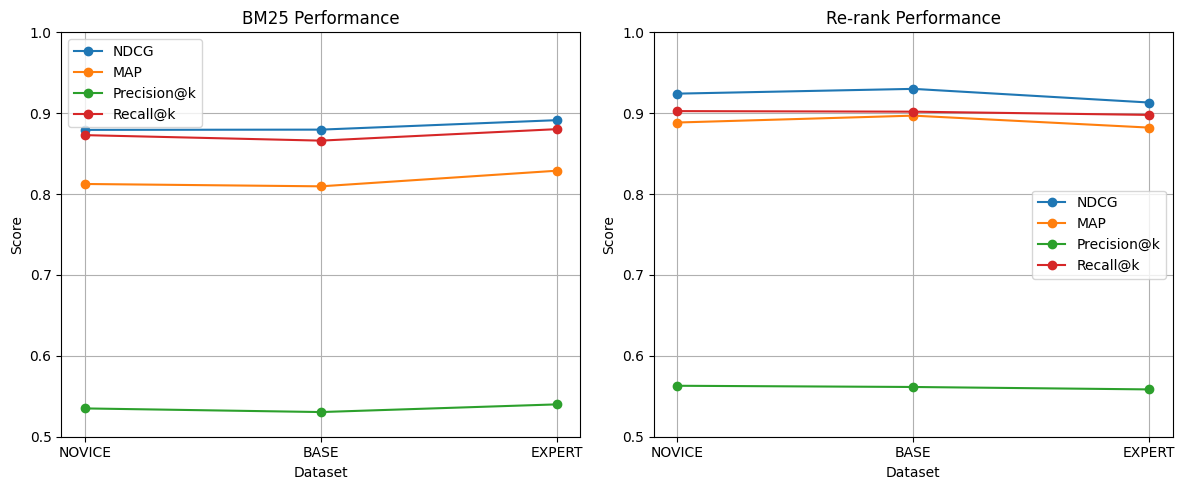

In [ ]:
# Plotting function
def plot_metrics(sub_df, title):
    x = sub_df['Dataset']
    plt.plot(x, sub_df['NDCG'], marker='o', label='NDCG')
    plt.plot(x, sub_df['MAP'], marker='o', label='MAP')
    plt.plot(x, sub_df['Precision@k'], marker='o', label='Precision@k')
    plt.plot(x, sub_df['Recall@k'], marker='o', label='Recall@k')
    plt.title(title)
    plt.xlabel("Dataset")
    plt.ylabel("Score")
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True)

# Create plots
plt.figure(figsize=(12, 5))

# BM25
plt.subplot(1, 2, 1)
plot_metrics(bm25_df, "BM25 Performance")

# Re-rank
plt.subplot(1, 2, 2)
plot_metrics(rerank_df, "Re-rank Performance")

plt.tight_layout()
plt.show()